In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import seaborn
from scipy.stats import sem
from scipy.stats import pearsonr as pearson_correlation
import pickle as pkl
import src.SessionNavigator as SessionNavigator
import src.SessionProcessor as SessionProcessor
from sklearn.svm import LinearSVC
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

c:\Users\Demogorgon\anaconda3\envs\Python37\lib\site-packages\allensdk\brain_observatory\comparison_utils.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
data_root = "C:/Users/Demogorgon/Documents/College/Marcus/Boston University PhD/Ocker Lab"
manifest_path = f"{data_root}/AllenSDK_Data/manifest.json"
save_path = f"{data_root}/correlations_and_bursts/data"

navigator = SessionNavigator.SessionNavigator(manifest_path)
acronyms = ['VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'LGd']
stim = 'drifting_gratings_contrast'
session_ids = navigator.find_sessions(acronyms, genotype="wt/wt", session_type="functional_connectivity")
#sessions = [navigator.load_session(session_id) for session_id in session_ids]
session = navigator.load_session(session_ids[0])
with open(f"{save_path}/{stim}__whole_burst_trains__session_{session_ids[0]}.pkl", 'rb') as f:
    bursts = pkl.load(f)
with open(f"{save_path}/{stim}__whole_single_trains__session_{session_ids[0]}.pkl", 'rb') as f:
    singles = pkl.load(f)

In [4]:
bin_start = 0.0
bin_stop = 0.3
bin_width = 0.1

processor = SessionProcessor.SessionProcessor(session)
unshuffled = processor.construct_decoder("drifting_gratings_contrast", "orientation", bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width, burst_dict=bursts, single_dict=singles, shuffle_trials=False)
shuffled = processor.construct_decoder("drifting_gratings_contrast", "orientation", bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width, burst_dict=bursts, single_dict=singles, shuffle_trials=True)

processor.construct_psth(unshuffled)
processor.construct_psth(shuffled)

processor.calculate_decoder_weights(unshuffled)
processor.calculate_decoder_weights(shuffled)

processor.calculate_correlations(unshuffled)
processor.calculate_correlations(shuffled)

results = processor.results()
unshuffled_results = results[unshuffled]
shuffled_results = results[shuffled]

unshuffled_psths = unshuffled_results["psths"]["bursts"]
shuffled_psths = shuffled_results["psths"]["bursts"]

In [5]:
a = unshuffled_psths == shuffled_psths
print(a.isin([True]))

<xarray.DataArray 'burst_counts' (stimulus_presentation_id: 540, time_relative_to_stimulus_onset: 3, unit_id: 784)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ..., False, False,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        [ True,  True,  True, ..., False, False,  True]],

       ...,

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True, False, ..., False,  True,  True]],

      

c:\Users\Demogorgon\anaconda3\envs\Python37\lib\site-packages\xarray\core\formatting.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(x, (float, np.float)):


In [6]:
BIN = 2

def correlate_noise(mat):
    # mat: num_presentations x num_units
    num_presentations, num_units = mat.shape
    # Average across the presentations
    expectation = np.array(mat.mean(axis=0))
    variance = np.array(mat.var(axis=0))
    centered_mat = mat-expectation
    covariance = np.dot(centered_mat.T, centered_mat)/num_presentations
    return np.divide(
        covariance,
        np.sqrt(
            np.outer(variance, variance)
            ), 
        out=np.full(covariance.shape, np.nan),
        where=True)

stim_table = unshuffled_results["decoder"].stim_table
bin_edges = unshuffled_results["decoder"].bin_edges
stim_conditions = unshuffled_results["decoder"].stimulus_conditions
sample_condition = stim_conditions[1]
#sample_unit_id = [951031834, 951028439]
sample_unit_id = processor.all_units
num_units = len(sample_unit_id)
presentation_ids = stim_table.loc[stim_table["orientation"] == sample_condition].index.to_numpy()

unshuffled_sample = processor.presentationwise_burst_counts(unshuffled, bin_edges, presentation_ids, sample_unit_id)
shuffled_sample = processor.presentationwise_burst_counts(shuffled, bin_edges, presentation_ids, sample_unit_id)
#print((unshuffled_sample == shuffled_sample).isin([True]))
#unshuffled_sample = unshuffled_sample[:,:,0]
#shuffled_sample = shuffled_sample[:,:,0]

upper_triangle_indices = np.triu_indices(n=num_units, k=1)
unshuffled_corr = correlate_noise(unshuffled_sample[:,BIN,:])[upper_triangle_indices].flatten()
shuffled_corr = correlate_noise(shuffled_sample[:,BIN,:])[upper_triangle_indices].flatten()

c:\Users\Demogorgon\anaconda3\envs\Python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


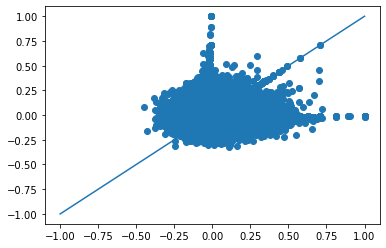

In [7]:
left_bound = -1
right_bound = 1
x = np.linspace(left_bound, right_bound, num=len(unshuffled_corr))
fig, ax = plt.subplots()
ax.scatter(unshuffled_corr, shuffled_corr)
ax.plot(x, x)
plt.show()

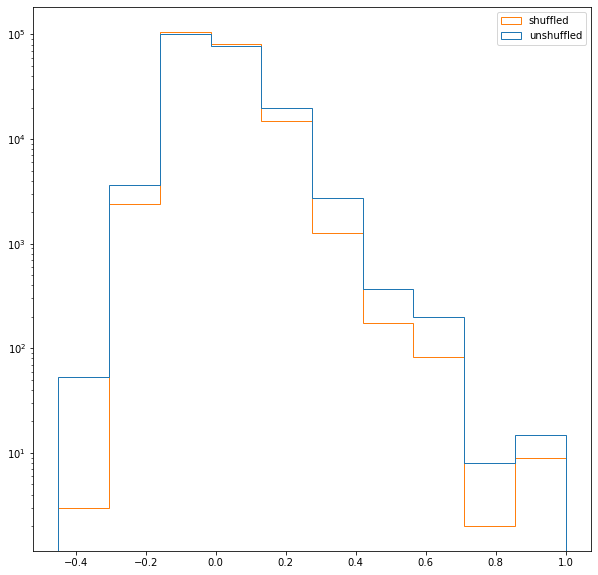

In [11]:
#                                         x   y
matplotlib.rcParams["figure.figsize"] = (10, 10)
hist_collection = [[]]*2
hist_collection[0] = unshuffled_corr
hist_collection[1] = shuffled_corr
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.hist(hist_collection, histtype="step", log=True, label=["unshuffled", "shuffled"])#, bins=np.arange(-1, 1, 0.01))#, log=True)
ax.legend()